✔ Base path exists: C:\Users\lasit\pneumonia_xray_project\data\raw\chest_xray
Found 5856 image paths.
Processing 300 images (set SAMPLE_LIMIT=None for full run).
  50/300 processed...
  100/300 processed...
  150/300 processed...
  200/300 processed...
  250/300 processed...
  300/300 processed...
Done in 113.1s | corrupt: 0
Preview of metrics:
                                                path  split   label status  \
0  C:\Users\lasit\pneumonia_xray_project\data\raw...  TRAIN  NORMAL     OK   
1  C:\Users\lasit\pneumonia_xray_project\data\raw...  TRAIN  NORMAL     OK   
2  C:\Users\lasit\pneumonia_xray_project\data\raw...  TRAIN  NORMAL     OK   

       mean       std       p01       p99   lap_var     w     h  \
0  0.505500  0.243094  0.023529  0.874510  0.002506  2090  1858   
1  0.394705  0.233087  0.000000  0.839216  0.002753  1422  1152   
2  0.478304  0.268945  0.000000  0.866667  0.002353  1810  1434   

                                       sha1  
0  c07a29214c98c92ed64657

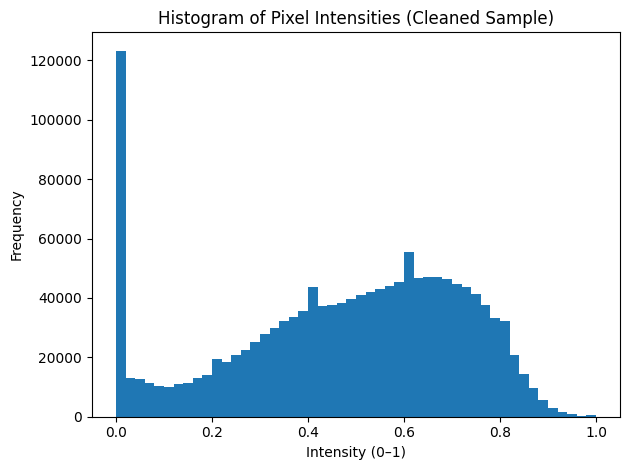

✔ Saved: C:\Users\lasit\pneumonia_xray_project\data\raw\chest_xray\_noise_plots\histogram_cleaned.png


C:\Users\lasit\AppData\Local\Temp\ipykernel_13008\1257127812.py:191: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=True)


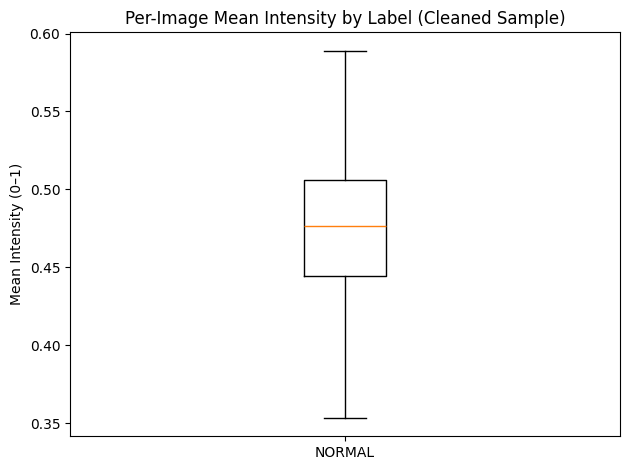

C:\Users\lasit\AppData\Local\Temp\ipykernel_13008\1257127812.py:197: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=True)


✔ Saved: C:\Users\lasit\pneumonia_xray_project\data\raw\chest_xray\_noise_plots\boxplot_mean_by_label.png

If you saw counts + a df preview + two plots, everything is working.
Set SAMPLE_LIMIT=None to process ALL images and re-run.


In [1]:
# ===== Fast, instrumented run (shows progress + saves plots) =====
import os, hashlib, time
from glob import glob
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

# ---------- CONFIG: set me ----------
base_path = r'C:\Users\lasit\pneumonia_xray_project\data\raw\chest_xray'  
SAMPLE_LIMIT = 300        # process first N images for quick feedback; set to None for all
TARGET_SIZE  = (256, 256)
MANIFEST_CSV = os.path.join(base_path, "noise_manifest.csv")
PLOT_DIR     = os.path.join(base_path, "_noise_plots")
# ------------------------------------

Path(PLOT_DIR).mkdir(parents=True, exist_ok=True)

def is_image_file(p): return os.path.splitext(p)[1].lower() in {".png",".jpg",".jpeg",".bmp",".tif",".tiff"}
def safe_open(path):
    try:
        with Image.open(path) as im:
            im.load()
            return im.copy()
    except Exception:
        return None
def to_gray_and_resize(img, size=TARGET_SIZE):
    if img.mode != "L": img = ImageOps.grayscale(img)
    if img.size != size: img = img.resize(size, Image.BILINEAR)
    return img
def normalize01(arr):
    if arr.dtype not in (np.float32, np.float64): arr = arr.astype(np.float32)
    return arr / 255.0
def laplacian_variance_np(arr01: np.ndarray) -> float:
    k = np.array([[0,1,0],[1,-4,1],[0,1,0]], dtype=np.float32)
    padded = np.pad(arr01, 1, mode="edge")
    h, w = arr01.shape
    out = np.empty_like(arr01, dtype=np.float32)
    for i in range(h):
        ri = i+1
        for j in range(w):
            rj = j+1
            out[i,j] = float((padded[ri-1:ri+2, rj-1:rj+2] * k).sum())
    return float(out.var())
laplacian_variance = laplacian_variance_np  # alias

def sha1sum(path):
    h = hashlib.sha1()
    with open(path,"rb") as f:
        for chunk in iter(lambda: f.read(8192), b""): h.update(chunk)
    return h.hexdigest()

def iter_dataset(base_dir):
    for split in ("train","test","val"):
        split_dir = os.path.join(base_dir, split)
        if not os.path.isdir(split_dir): continue
        for label in os.listdir(split_dir):
            label_dir = os.path.join(split_dir, label)
            if not os.path.isdir(label_dir): continue
            for p in glob(os.path.join(label_dir, "*")):
                if is_image_file(p):
                    yield p, split.upper(), label.upper()

# ---- sanity: path exists?
assert os.path.isdir(base_path), f"base_path does not exist: {base_path}"
print("✔ Base path exists:", base_path)

# ---- collect paths (not opening files yet)
all_items = list(iter_dataset(base_path))
print(f"Found {len(all_items)} image paths.")
if len(all_items) == 0:
    raise SystemExit("No images found. Check base_path and subfolders (train/test/val).")

# ---- limit for quick feedback
items = all_items[:SAMPLE_LIMIT] if SAMPLE_LIMIT else all_items
print(f"Processing {len(items)} images (set SAMPLE_LIMIT=None for full run).")

# ---- scan + metrics with progress prints
records, skipped = [], 0
t0 = time.time()
for idx, (path, split, label) in enumerate(items, start=1):
    img = safe_open(path)
    if img is None:
        skipped += 1
        records.append({"path":path,"split":split,"label":label,"status":"CORRUPT",
                        "mean":np.nan,"std":np.nan,"p01":np.nan,"p99":np.nan,
                        "lap_var":np.nan,"w":np.nan,"h":np.nan,"sha1":None})
    else:
        w,h = img.size
        img = to_gray_and_resize(img, TARGET_SIZE)
        arr = np.array(img)
        arr01 = normalize01(arr)
        mean = float(arr01.mean())
        std  = float(arr01.std())
        p01  = float(np.percentile(arr01, 1))
        p99  = float(np.percentile(arr01, 99))
        lap  = laplacian_variance(arr01)
        sha1 = sha1sum(path)
        records.append({"path":path,"split":split,"label":label,"status":"OK",
                        "mean":mean,"std":std,"p01":p01,"p99":p99,
                        "lap_var":lap,"w":w,"h":h,"sha1":sha1})

    if idx % 50 == 0 or idx == len(items):
        print(f"  {idx}/{len(items)} processed...")

print(f"Done in {time.time()-t0:.1f}s | corrupt: {skipped}")

df = pd.DataFrame.from_records(records)
print("Preview of metrics:")
print(df.head(3))

# ---- outlier flags (simple)
def iqr_bounds(s, k=1.5):
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    return q1 - k*iqr, q3 + k*iqr

df["flag_outlier"] = False
df["reasons"] = [[] for _ in range(len(df))]

for split in df["split"].dropna().unique():
    for label in df.loc[df["split"]==split, "label"].dropna().unique():
        sub = (df["split"]==split) & (df["label"]==label) & (df["status"]=="OK")
        if sub.sum() < 8: continue
        for metric in ("mean","std","lap_var"):
            lb, ub = iqr_bounds(df.loc[sub, metric])
            idx = sub & ((df[metric] < lb) | (df[metric] > ub))
            df.loc[idx, "flag_outlier"] = True
            df.loc[idx, "reasons"] = df.loc[idx, "reasons"].apply(lambda r: r + [f"{metric}_IQR"])

df["reasons"] = df["reasons"].apply(lambda r: ";".join(r) if r else "")

# ---- save manifest (even for sample run)
df.to_csv(MANIFEST_CSV, index=False)
print("✔ Manifest saved:", MANIFEST_CSV)

# ---- summaries
print("\nCounts by split/label (OK only):")
counts = Counter((row["label"], row["split"]) for _, row in df.iterrows() if row["status"]=="OK")
for (label, split), c in counts.items():
    print(f"{split}/{label}: {c}")

print("\nOutlier rate by split/label:")
print(df.groupby(["split","label"])["flag_outlier"].mean().rename("outlier_rate").reset_index())

# ---- plots (show + save)
def histogram_pixel_intensities():
    ok = df[(df["status"]=="OK") & (~df["flag_outlier"])]
    if ok.empty:
        print("No OK images for histogram.")
        return
    rng = np.random.default_rng(42)
    vals = []
    for p in ok["path"].tolist()[:min(len(ok), 1000)]:
        with Image.open(p) as im:
            im = to_gray_and_resize(im, TARGET_SIZE)
            arr01 = normalize01(np.array(im)).ravel()
            if arr01.size > 5000:
                idx = rng.choice(arr01.size, 5000, replace=False)
                arr01 = arr01[idx]
            vals.append(arr01)
    if not vals: 
        print("No pixel data collected.")
        return
    vals = np.concatenate(vals, axis=0)
    plt.figure()
    plt.hist(vals, bins=50)
    plt.title("Histogram of Pixel Intensities (Cleaned Sample)")
    plt.xlabel("Intensity (0–1)"); plt.ylabel("Frequency")
    plt.tight_layout(); plt.show()
    out = os.path.join(PLOT_DIR, "histogram_cleaned.png")
    plt.figure()
    plt.hist(vals, bins=50)
    plt.title("Histogram of Pixel Intensities (Cleaned Sample)")
    plt.xlabel("Intensity (0–1)"); plt.ylabel("Frequency")
    plt.tight_layout(); plt.savefig(out, dpi=150); plt.close()
    print("✔ Saved:", out)

def boxplot_per_image_mean_by_label():
    ok = df[(df["status"]=="OK") & (~df["flag_outlier"])]
    if ok.empty:
        print("No OK images for boxplot.")
        return
    grouped = ok.groupby("label")["mean"].apply(list)
    labels = sorted(grouped.index)
    data = [grouped[l] for l in labels]
    plt.figure()
    plt.boxplot(data, labels=labels, showfliers=True)
    plt.title("Per-Image Mean Intensity by Label (Cleaned Sample)")
    plt.ylabel("Mean Intensity (0–1)")
    plt.tight_layout(); plt.show()
    out = os.path.join(PLOT_DIR, "boxplot_mean_by_label.png")
    plt.figure()
    plt.boxplot(data, labels=labels, showfliers=True)
    plt.title("Per-Image Mean Intensity by Label (Cleaned Sample)")
    plt.ylabel("Mean Intensity (0–1)")
    plt.tight_layout(); plt.savefig(out, dpi=150); plt.close()
    print("✔ Saved:", out)

histogram_pixel_intensities()
boxplot_per_image_mean_by_label()

print("\nIf you saw counts + a df preview + two plots, everything is working.")
print("Set SAMPLE_LIMIT=None to process ALL images and re-run.")
